<a href="https://colab.research.google.com/github/BielSousa/EstudosML/blob/main/RandomForestClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Telecom Churn
---
    Autor: Gabriel Farias
    Data: 28/08/2021
---
>**Churn** é uma métrica que indica o quanto sua empresa perdeu de
    receita ou clientes. Para calcular o churn, basta dividir a
    quantidade de clientes que perdeu até o final do período pelo
    total de clientes que iniciaram. 
>
>  **Exemplo: se você perdeu 10 clientes de 100 = 10% de churn rate.**
---

### Este estudo visa calcular a futura taxa de churn de uma empresa de telecom

In [128]:
# Import das bibliotecas utlizadas no estudo
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

In [111]:
# Criando os dataframes
'''
    Seram duas bases serapadas uma com dados que iremos estudar "churn-bigml-80.csv" 
e ou quer iremos utilizar para simular o mundo real, onde não sabemos os novos dados.
Entretando já iremos deixar todos os dados em memória.
'''
df20 = pd.read_csv('/content/churn-bigml-20.csv')
df80 = pd.read_csv('/content/churn-bigml-80.csv')

### Exploração do Dataset

In [112]:
df80.columns 

Index(['State', 'Account length', 'Area code', 'International plan',
       'Voice mail plan', 'Number vmail messages', 'Total day minutes',
       'Total day calls', 'Total day charge', 'Total eve minutes',
       'Total eve calls', 'Total eve charge', 'Total night minutes',
       'Total night calls', 'Total night charge', 'Total intl minutes',
       'Total intl calls', 'Total intl charge', 'Customer service calls',
       'Churn'],
      dtype='object')

In [113]:
df80.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2666 entries, 0 to 2665
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   State                   2666 non-null   object 
 1   Account length          2666 non-null   int64  
 2   Area code               2666 non-null   int64  
 3   International plan      2666 non-null   object 
 4   Voice mail plan         2666 non-null   object 
 5   Number vmail messages   2666 non-null   int64  
 6   Total day minutes       2666 non-null   float64
 7   Total day calls         2666 non-null   int64  
 8   Total day charge        2666 non-null   float64
 9   Total eve minutes       2666 non-null   float64
 10  Total eve calls         2666 non-null   int64  
 11  Total eve charge        2666 non-null   float64
 12  Total night minutes     2666 non-null   float64
 13  Total night calls       2666 non-null   int64  
 14  Total night charge      2666 non-null   

        Podemos observar que não temos nenhum valor nulo.
        Sabemos que no mundo real a realidade seria diferente, entretanto
    para fins de estudo esta base de dados irá servir.
    

In [114]:
df80.head(6)

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False
5,AL,118,510,Yes,No,0,223.4,98,37.98,220.6,101,18.75,203.9,118,9.18,6.3,6,1.70,0,False


In [115]:
# Transformarção de variáveis categoricas [Internacional plan, Voice email plan e Churn] em discretas
df80['International plan'] = df80['International plan'].map(lambda x: 1 if x == 'Yes' else 0) 
df80['Voice mail plan'] = df80['Voice mail plan'].map(lambda x: 1 if x == 'Yes' else 0)
df80['Churn'] = df80['Churn'].map(lambda x: 1 if x else 0)
df20['International plan'] = df20['International plan'].map(lambda x: 1 if x == 'Yes' else 0) 
df20['Voice mail plan'] = df20['Voice mail plan'].map(lambda x: 1 if x == 'Yes' else 0)
df20['Churn'] = df20['Churn'].map(lambda x: 1 if x else 0)

In [116]:
df80.head(6)

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0
1,OH,107,415,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
2,NJ,137,415,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
3,OH,84,408,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
4,OK,75,415,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0
5,AL,118,510,1,0,0,223.4,98,37.98,220.6,101,18.75,203.9,118,9.18,6.3,6,1.70,0,0


In [117]:
# Verificando se há mais de um código de área por estado
df80.groupby(['State','Area code'])['State'].count()

State  Area code
AK     408           9
       415          21
       510          13
AL     408          22
       415          32
                    ..
WV     415          46
       510          27
WY     408          15
       415          35
       510          16
Name: State, Length: 153, dtype: int64

        Como há mais de um código de area por estado, transformaremos
    estado em variável discreta utilizando o LabelEncoder.
        O LabelEncoder, considera a ordem alfabetica na hora de fazer
    a transformação.

In [118]:
# Primeiros 10 estados após a transformação
for num, state in enumerate(sorted(df80['State'].unique())):
    print(num+1,': ',state)
    if num == 9:
        break

1 :  AK
2 :  AL
3 :  AR
4 :  AZ
5 :  CA
6 :  CO
7 :  CT
8 :  DC
9 :  DE
10 :  FL


In [119]:
label_encoder = LabelEncoder()
df80['State'] = label_encoder.fit_transform(df80['State'])
df80.head(5)

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,16,128,415,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0
1,35,107,415,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
2,31,137,415,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
3,35,84,408,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
4,36,75,415,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0


### Exploração das variáveis

In [120]:
df80.describe()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
count,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.00000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000
mean,26.036009,100.620405,437.438860,0.101275,0.274944,8.021755,179.48162,100.310203,30.512404,200.386159,100.023631,17.033072,201.168942,100.106152,9.052689,10.237022,4.467367,2.764490,1.562641,0.145536
std,14.921792,39.563974,42.521018,0.301750,0.446570,13.612277,54.21035,19.988162,9.215733,50.951515,20.161445,4.330864,50.780323,19.418459,2.285120,2.788349,2.456195,0.752812,1.311236,0.352707
min,0.000000,1.000000,408.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,43.700000,33.000000,1.970000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,13.000000,73.000000,408.000000,0.000000,0.000000,0.000000,143.40000,87.000000,24.380000,165.300000,87.000000,14.050000,166.925000,87.000000,7.512500,8.500000,3.000000,2.300000,1.000000,0.000000
50%,26.000000,100.000000,415.000000,0.000000,0.000000,0.000000,179.95000,101.000000,30.590000,200.900000,100.000000,17.080000,201.150000,100.000000,9.050000,10.200000,4.000000,2.750000,1.000000,0.000000
75%,39.000000,127.000000,510.000000,0.000000,1.000000,19.000000,215.90000,114.000000,36.700000,235.100000,114.000000,19.980000,236.475000,113.000000,10.640000,12.100000,6.000000,3.270000,2.000000,0.000000
max,50.000000,243.000000,510.000000,1.000000,1.000000,50.000000,350.80000,160.000000,59.640000,363.700000,170.000000,30.910000,395.000000,166.000000,17.770000,20.000000,20.000000,5.400000,9.000000,1.000000


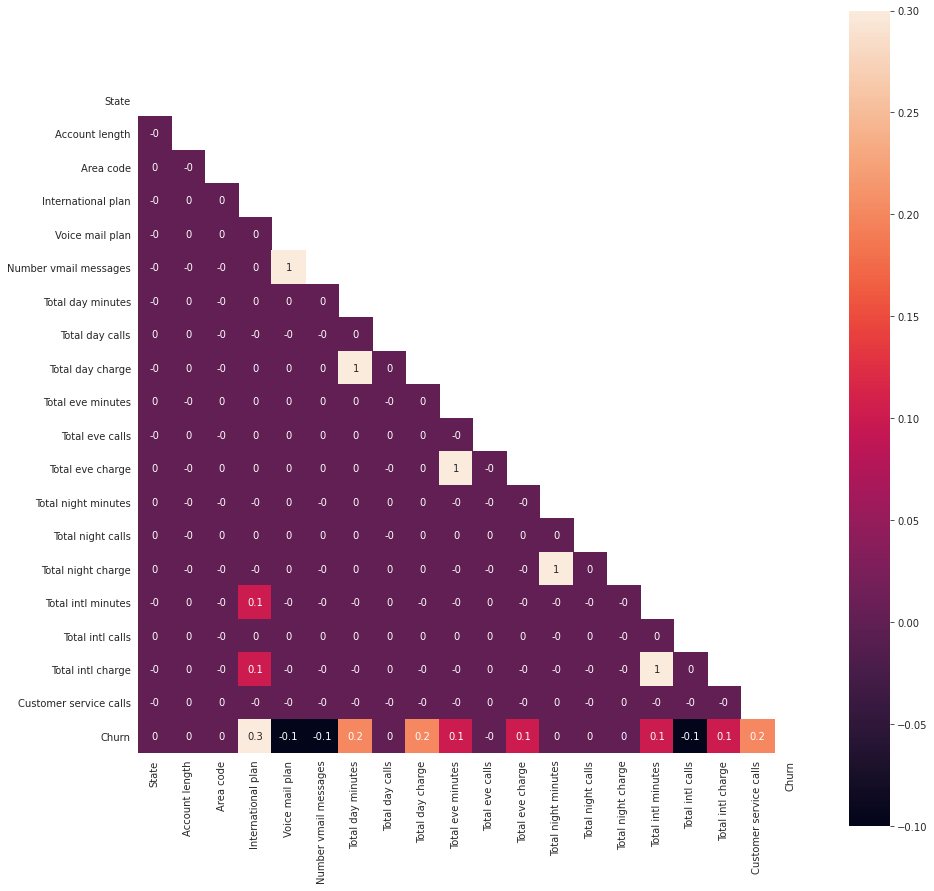

In [121]:
corr = df80.corr().round(1)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(15, 15))
    ax = sns.heatmap(corr, mask=mask, vmax=.3, square=True,annot=True)

        Após essa verificação de correlação daremos um drop nas variáveis
    que tem uma baixa correlação com o Churn um total de 11 variáveis 
    restando apenas 8.
    
        Variaveis excluídas
        - State
        - Account Length
        - Area code
        - Voice mail plan
        - Numbers vmail messages
        - Total day calls
        - Total eve calls
        - Total night minutes 
        - Total night calls
        - Total night charge
        - Total intl calls

In [122]:
df80.drop(columns=['State', 'Account length', 'Area code',
       'Voice mail plan', 'Number vmail messages',
       'Total day calls', 
       'Total eve calls',  'Total night minutes',
       'Total night calls', 'Total night charge',
       'Total intl calls'], inplace=True)

#fazendo o drop no df20 também
df20.drop(columns=['State', 'Account length', 'Area code',
       'Voice mail plan', 'Number vmail messages',
       'Total day calls', 
       'Total eve calls',  'Total night minutes',
       'Total night calls', 'Total night charge',
       'Total intl calls'], inplace=True)

In [95]:
df80.head(5)

,International plan,Total day minutes,Total day charge,Total eve minutes,Total eve charge,Total intl minutes,Total intl charge,Customer service calls,Churn
0,0,265.1,45.07,197.4,16.78,10.0,2.70,1,0
1,0,161.6,27.47,195.5,16.62,13.7,3.70,1,0
2,0,243.4,41.38,121.2,10.30,12.2,3.29,0,0
3,1,299.4,50.90,61.9,5.26,6.6,1.78,2,0
4,1,166.7,28.34,148.3,12.61,10.1,2.73,3,0


# Aplicação de modelo de machine learnig (Random Forest)

In [124]:
x_train, x_test, y_train, y_test = df80.drop(columns='Churn'),df20.drop(columns='Churn'),df80['Churn'],df20['Churn']

In [125]:
mod1 = RandomForestClassifier(random_state=0)
mod1.fit(x_train,y_train)
p = mod1.predict(x_test)

In [135]:
print(f'Acurácia: {mod1.score(x_test,y_test)*100:.2f} %')

Acurácia: 91.60 %


In [145]:
print(f'taxa de churn prevista: {p.sum()/len(p)*100:.2f}%')

taxa de churn prevista: 11.54%


In [156]:
# Limites Inferior e Superior
print(f'taxa de churn superior: {((p.sum()+p.sum()*0.1)/len(p)*100):.2f}%')
print(f'taxa de churn inferior: {((p.sum()-p.sum()*0.1)/len(p)*100):.2f}%')

taxa de churn prevista: 12.70%
taxa de churn prevista: 10.39%


## Conclusão
        Através da aplicação do modelo conseguimos chegar em uma acurácia de 
    91% em prever se hávera churn do cliente ou não.
        Utilizando 10% de limites inferior e superior chegamos que nossa
    taxa de churn será entre 10.39% e 12.70%.
        
        Se supormos que cada cliente gere a receita R$ 100.00 para empresa 
    a cada 100 novos clientes, a empresa terá a certaza de um faturamento
    liquído de entre R$ 8730,00 e R$8961,00